## 1. Importing required packages and read the prepared data

In [47]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
sns.set_palette('coolwarm')
sns.set(rc= {'image.cmap': 'coolwarm'})
%matplotlib inline


df= pd.read_excel("user_deposit_test.xlsx")
df.head()

,frequency,date_deposit,deposit,login_id
0,6,2010-12-01 08:26:00,2.55,17850.0
1,6,2010-12-01 08:26:00,3.39,17850.0
2,8,2010-12-01 08:26:00,2.75,17850.0
3,6,2010-12-01 08:26:00,3.39,17850.0
4,6,2010-12-01 08:26:00,3.39,17850.0


## 2. Set date to datetime format

In [48]:
import datetime as dt
df['date_deposit'] =  pd.to_datetime(df['date_deposit']).dt.date

## 3. Cleaning and selecting only required column

In [49]:
df = df[pd.notnull(df['login_id'])]
df = df[(df['frequency'])>0]

In [50]:
df['deposit'] = df['frequency']* df['deposit']
cols_of_interest = ['login_id', 'date_deposit', 'deposit']
df = df[cols_of_interest]

In [51]:
print(df.head())
print(df['login_id'].nunique())

   login_id date_deposit  deposit
0   17850.0   2010-12-01    15.30
1   17850.0   2010-12-01    20.34
2   17850.0   2010-12-01    22.00
3   17850.0   2010-12-01    20.34
4   17850.0   2010-12-01    20.34
4339


## 4. Importing lifetimes package to view our data into RFM metrics

In [52]:
from lifetimes.plotting import *
from lifetimes.utils import *


data = summary_data_from_transaction_data(df, 'login_id','date_deposit', monetary_value_col = 'deposit', observation_period_end = '2011-12-9')
data.head()

,frequency,recency,T,monetary_value
login_id,,,,
12346.0,0.0,0.0,325.0,0.000000
12347.0,6.0,365.0,367.0,599.701667
12348.0,3.0,283.0,358.0,301.480000
12349.0,0.0,0.0,18.0,0.000000
12350.0,0.0,0.0,310.0,0.000000


## 5. Exploring the frequency of deposit

count    4339.000000
mean        2.864024
std         5.952745
min         0.000000
25%         0.000000
50%         1.000000
75%         3.000000
max       131.000000
Name: frequency, dtype: float64
0.3569946992394561


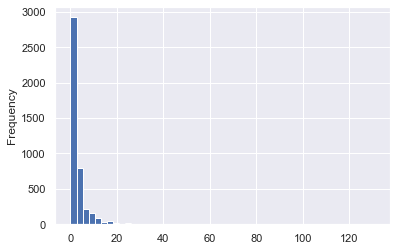

In [53]:
data['frequency'].plot(kind='hist', bins=50)
print(data['frequency'].describe())
print(sum(data['frequency'] == 0)/float(len(data)))

## 6. Fitting the model

In [54]:
from lifetimes import BetaGeoFitter

bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(data['frequency'],data['recency'],data['T'])
print(bgf)
bgf.summary

<lifetimes.BetaGeoFitter: fitted with 4339 subjects, a: 0.00, alpha: 68.89, b: 6.75, r: 0.83>


,coef,se(coef),lower 95% bound,upper 95% bound
r,0.826433,0.026780,0.773944,0.878922
alpha,68.890678,2.611055,63.773011,74.008345
a,0.003443,0.010347,-0.016837,0.023722
b,6.749363,22.412933,-37.179985,50.678711


## 7. Visualizing the frequency/recency metrics

Text(0.5, 1.0, 'Expected Number of Future Deposit for 1 Unit of Time by Frequency and Recency of a Client')

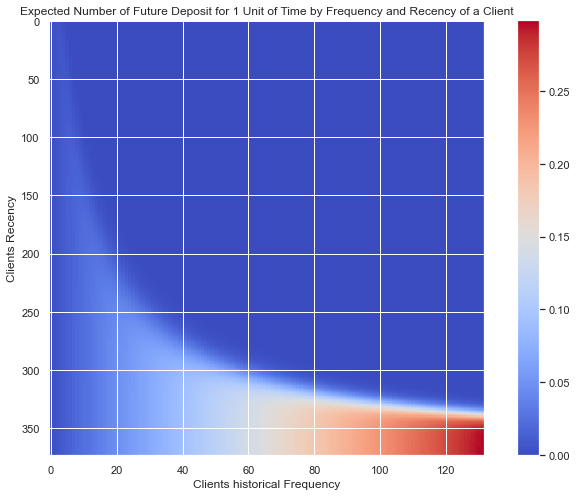

In [55]:
from lifetimes.plotting import plot_frequency_recency_matrix
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12,8))
plot_frequency_recency_matrix(bgf)
plt.xlabel("Clients historical Frequency")
plt.ylabel("Clients Recency")
plt.title("Expected Number of Future Deposit for 1 Unit of Time by Frequency and Recency of a Client")

## 8. Visualizing the probability of being alive

Text(0.5, 1.0, 'Probability Client is Alive by Frequency and Recency of a Client')

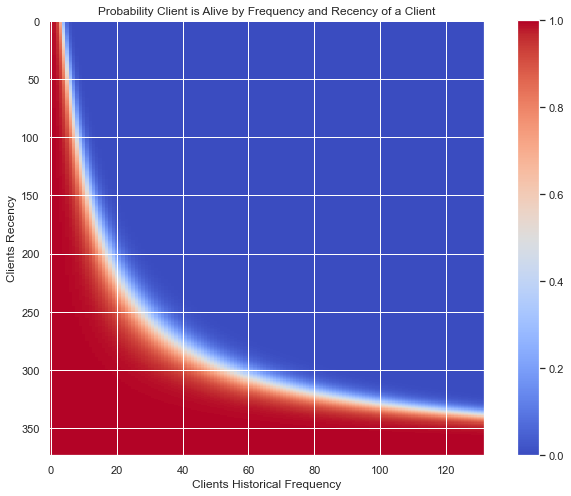

In [56]:
from lifetimes.plotting import plot_probability_alive_matrix
fig =plt.figure(figsize = (12,8))
plot_probability_alive_matrix(bgf)
plt.xlabel("Clients Historical Frequency")
plt.ylabel("Clients Recency")
plt.title("Probability Client is Alive by Frequency and Recency of a Client")

## 9. Predict expected deposit and rank the client in the next period

In [57]:
t = 1
data['predicted_deposit'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, data['frequency'], data['recency'], data['T'])
data.sort_values(by = 'predicted_deposit').tail(5)

,frequency,recency,T,monetary_value,predicted_deposit
login_id,,,,,
14606.0,88.0,372.0,373.0,135.890114,0.201005
15311.0,89.0,373.0,373.0,677.729438,0.203269
17841.0,111.0,372.0,373.0,364.452162,0.253053
12748.0,113.0,373.0,373.0,298.360885,0.257581
14911.0,131.0,372.0,373.0,1093.661679,0.298312


## 10. Assessing model fit

<AxesSubplot:title={'center':'Frequency of Repeat Transactions'}, xlabel='Number of Calibration Period Transactions', ylabel='Customers'>

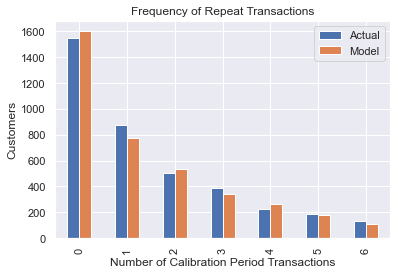

In [58]:
from lifetimes.plotting import plot_period_transactions
plot_period_transactions(bgf)

## 11. Partitioned data into calibration (insample) and holdout (validation) set

In [64]:
from lifetimes.utils import calibration_and_holdout_data

summary_cal_holdout = calibration_and_holdout_data(df, 'login_id', 'date_deposit',
                                                  calibration_period_end = '2011-06-08',
                                                  observation_period_end = '2011-12-9')
summary_cal_holdout.head()

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
login_id,,,,,
12346.0,0.0,0.0,141.0,0.0,184.0
12347.0,2.0,121.0,183.0,4.0,184.0
12348.0,2.0,110.0,174.0,1.0,184.0
12350.0,0.0,0.0,126.0,0.0,184.0
12352.0,3.0,34.0,112.0,3.0,184.0


## 12. Visualize the calibration vs holdout set

Text(0.5, 1.0, 'Actual Deposit in Holdout Period vs Predicted Deposit')

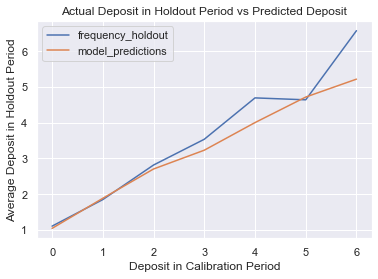

In [67]:
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases

bgf.fit(summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])
plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout)

plt.ylabel("Average Deposit in Holdout Period")
plt.xlabel("Deposit in Calibration Period")
plt.title("Actual Deposit in Holdout Period vs Predicted Deposit")